In [1]:
import os
import sys
import h5py
from pathlib import Path

sys.path.append('../')
from source.computation_support import *
from source.myGaborFunctions import *
from source.color_transformations import *
from source.plot_save_figures import *
from source.graph_operations import *
from source.chameleon import *

from source.color_seg_methods import *
# %matplotlib qt

29030.jpg


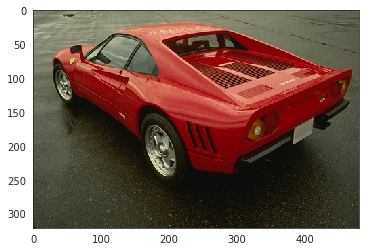

In [2]:
# Read and show input image
inDir = '../../data/images/500images/test/'
list_imgs = os.listdir(inDir)
img_file = list_imgs[15]
print(img_file)
img = io.imread(inDir + img_file)
rows, cols, channels = img.shape
plt.imshow(img)

SLIC number of regions: 2391


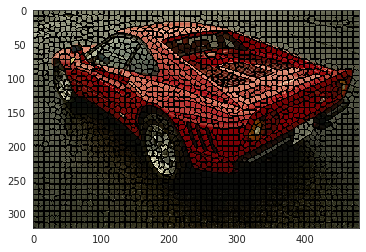

In [3]:
# Compute superpixels
convert2lab = True
n_slic = 500 * 5
regions_slic = slic_superpixel(img, n_slic, convert2lab)

superpixels = segmentation.mark_boundaries(img, regions_slic, color=(0, 0, 0), mode='thick')
superpixels = np.array(superpixels * 255, np.uint8)
plt.imshow(superpixels)


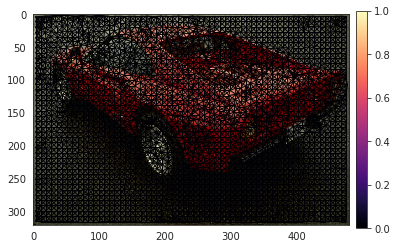

In [4]:
# Generating superpixels graph
graph_type = '8nn'
graph_raw = get_graph(img, regions_slic, graph_type)

lc = graph.show_rag(regions_slic, graph_raw, img, edge_width=1, img_cmap=None, border_color=None)
colbar_lim = (0, 1)
lc.set_clim(colbar_lim[0], colbar_lim[1])
plt.colorbar(lc, fraction=0.0355, pad=0.02)
plt.imshow(img)  


In [5]:
graph_raw[1][0]['weight']

0

In [6]:
graph_raw[1][0]['similarity']

1

In [7]:
# Reading predicted gradients from h5 files
source_dir = os.path.abspath('') + '/'
num_imgs = 500
gradients_dir = 'predicted_gradients'
similarity_measure = 'OT'
learning_method = 'MLPR_tf'
gabor_config = '4f_4a_2p_25p_1.00fb_45ab_0.90cpf_0.90cpa_3.0stds'
graph_slic = str(n_slic) + '_slic_' + graph_type + '_' + similarity_measure 

hdf5_indir_im = Path( '../../data/hdf5_datasets/' + str(num_imgs) + 'images/' + 'images')
hdf5_indir_grad = Path('../../data/hdf5_datasets/' + str(num_imgs) + 'images/' + gradients_dir + '/' + graph_slic + '/' + learning_method + '/' + gabor_config)

images_file = h5py.File(hdf5_indir_im / "Berkeley_images.h5", "r+")
img_subdirs = np.array(images_file["/image_subdirs"])
imgs_gradients_file = h5py.File(hdf5_indir_grad / 'predicted_gradients.h5', "r+")

img_ids = np.array(images_file["/image_ids"])
imgs_gradients = np.array(imgs_gradients_file["/predicted_gradients"])
    
test_indices = []
for ii in range(len(img_ids)):
    if img_subdirs[ii] == 'test':
        test_indices.append(ii)

img_ids = img_ids[test_indices]  
img_id = img_file.split('.')[0]
indx = np.where(img_ids==img_id)
y_pred = imgs_gradients[indx][0]


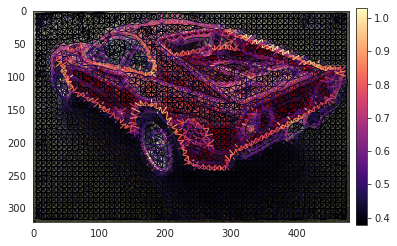

In [8]:
# updating the edge weigths with predicted gradients
graph_pred = graph_raw.copy()
for i_edge, e in enumerate(list(graph_raw.edges)):
    graph_pred[e[0]][e[1]]['weight'] = y_pred[i_edge]#
    graph_pred[e[0]][e[1]]['similarity'] = int(1.0/y_pred[i_edge]* 1e4)
    
graph_pred.graph['edge_weight_attr'] = 'similarity'
lc = graph.show_rag(regions_slic, graph_pred, img, edge_width=1, img_cmap=None, border_color=None)
colbar_lim = (min(y_pred), max(y_pred))
lc.set_clim(colbar_lim[0], colbar_lim[1])
plt.colorbar(lc, fraction=0.0355, pad=0.02)
plt.imshow(img) 

Number of MST edges: 2390
Max edge weight: 0.43227977 Min edge weight: 0.0
(1.0893642657602207, -0.0003880461655940689, 0.015702144431893734)
Threshold: 0.06303794744515334


Text(0.06303794744515334, 10.55264090052089, 'threshold')

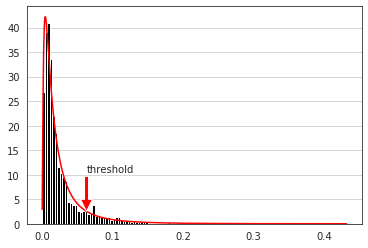

In [18]:
# Performing threshold graphcut
graph_weighted = graph_raw.copy()
y_pred_norm = (y_pred - min(y_pred)) / (max(y_pred) - min(y_pred))

for i_edge, e in enumerate(list(graph_raw.edges)):
    graph_weighted[e[0]][e[1]]['weight'] = y_pred_norm[i_edge]#

graph_mode = 'mst'

if graph_mode == 'complete':
    weights = nx.get_edge_attributes(graph_weighted, 'weight').values()
elif graph_mode == 'mst':
    # Compute Minimum Spanning Tree
    graph_mst = get_mst(graph_weighted)
    weights = nx.get_edge_attributes(graph_mst, 'weight').values()
    graph_weighted = graph_mst

    
cut_level = 0.9   
law_type = 'log'
thresh, params = fit_distribution_law(list(weights), cut_level, law_type)

x = np.linspace(0, max(weights), 1000)
if law_type == 'gamma':
    pdf_fitted = gamma.pdf(x, *params)
    thr_pos = gamma.pdf(thresh, *params)
elif law_type == 'log':
    pdf_fitted = lognorm.pdf(x, *params)
    thr_pos = lognorm.pdf(thresh, *params)
elif law_type == 'beta':
    pdf_fitted = beta.pdf(x, *params)
    thr_pos = beta.pdf(thresh, *params)
    
plt.hist(weights, bins='auto', color='k', density=True)
plt.plot(x, pdf_fitted, color='r')
plt.grid(axis='y')
plt.annotate('threshold', xy=(thresh, thr_pos), xytext=(thresh, pdf_fitted.max()/4), arrowprops=dict(facecolor='red', shrink=2))


Number of regions after graph cut: 283


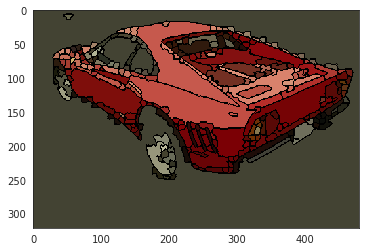

In [19]:
graph_aftercut = graph_weighted.copy()
graph.cut_threshold(regions_slic, graph_aftercut, thresh, in_place=True)
regions_aftercut = graph2regions(graph_aftercut, regions_slic)
weights_aftercut = nx.get_edge_attributes(graph_aftercut, 'weight').values()

out = color.label2rgb(regions_aftercut, img, kind='avg')
out = segmentation.mark_boundaries(out, regions_aftercut, color=(0, 0, 0), mode='thick')
ax = plt.gca()
ax.imshow(out)

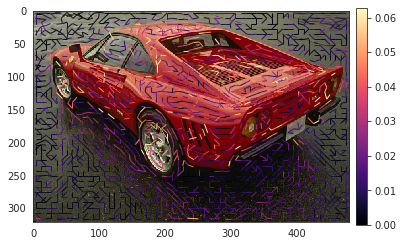

In [20]:
lc = graph.show_rag(regions_slic, graph_aftercut, img, edge_width=1, img_cmap=None, border_color=None)
colbar_lim = (min(weights_aftercut), max(weights_aftercut))
lc.set_clim(colbar_lim[0], colbar_lim[1])
plt.colorbar(lc, fraction=0.0355, pad=0.02)
plt.imshow(img) 

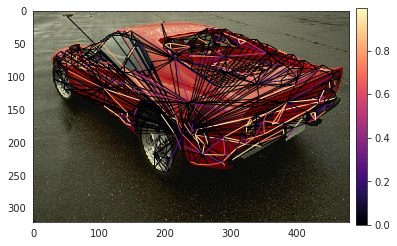

In [21]:
# Generating after cut graph
graph_type = 'rag'
# graph_raw = get_graph(img, regions_aftercut, graph_type)
graph_mean_color = graph.rag_mean_color(img, regions_aftercut, mode='similarity')

lc = graph.show_rag(regions_aftercut, graph_mean_color, img, edge_width=1, img_cmap=None, border_color=None)
# colbar_lim = (0, 1)
# lc.set_clim(colbar_lim[0], colbar_lim[1])
plt.colorbar(lc, fraction=0.0355, pad=0.02)
plt.imshow(img)  

In [22]:
for i_edge, e in enumerate(list(graph_mean_color.edges)):
    graph_mean_color[e[0]][e[1]]['similarity'] = graph_mean_color[e[0]][e[1]]['weight'] 
graph_mean_color.graph['edge_weight_attr'] = 'similarity'


In [23]:
graph_mean_color[0][1]['similarity']

6.453811734373648e-07

In [24]:
graph_mean_color[0][1]['weight']

6.453811734373648e-07

In [25]:
# Preparing data for chameleon
centroids = nx.get_node_attributes(graph_mean_color, 'centroid').values()

for i, p in enumerate(graph_mean_color.nodes()):
    graph_mean_color.nodes[p]['cluster'] = graph_mean_color.nodes[p]['labels'][0]

df = pd.DataFrame.from_dict(centroids)

df['cluster'] = nx.get_node_attributes(graph_mean_color, 'cluster').values()

In [26]:
init_clusters = int(len(centroids))
print(init_clusters)
final_clusters = 4
alpha = 2
iterm = tqdm(enumerate(range(init_clusters - final_clusters)), total=init_clusters - final_clusters)
for i in iterm:
    merge_best(graph_mean_color, df, alpha, final_clusters, verbose=False)
#     plot2d_data(df)

  0%|          | 0/279 [00:00<?, ?it/s]

283


../source/chameleon.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  return EC / ((ECci + ECcj) / 2.0)
/home/eric/anaconda3/envs/py3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eric/anaconda3/envs/py3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
../source/chameleon.py:37: RuntimeWarning: invalid value encountered in double_scalars
  return SEC / ((Ci / (Ci + Cj) * SECci) + (Cj / (Ci + Cj) * SECcj))
100%|██████████| 279/279 [55:32<00:00, 11.94s/it]


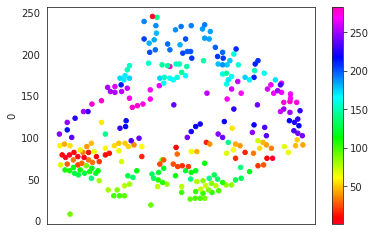

In [30]:
res = rebuild_labels(df)
plot2d_data(res)

In [37]:
map_array = np.zeros(regions_slic.max() + 1, dtype=regions_slic.dtype)
# Mapping from old labels to new
for n, d in graph_mean_color.nodes(data=True):
    map_array[d['labels']] = d['cluster']

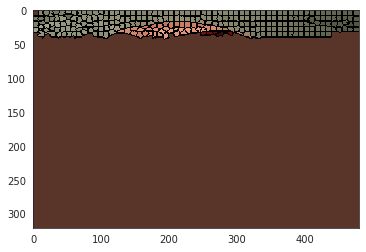

In [38]:
regions_cham = map_array[regions_slic]
out = color.label2rgb(regions_cham, img, kind='avg')
out = segmentation.mark_boundaries(out, regions_cham, color=(0, 0, 0), mode='thick')
ax = plt.gca()
ax.imshow(out)


Number of regions after graph cut: 2109


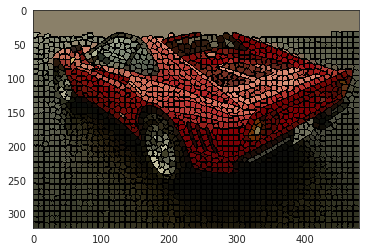

In [32]:
regions_cham = graph2regions(graph_mean_color, regions_slic)
# map_array = np.zeros(regions_aftercut.max() + 1, dtype=regions_aftercut.dtype)
# # Mapping from old labels to new
# for n, d in graph_mean_color.nodes(data=True):
#     map_array[d['labels']] = d['cluster']
    
# regions_cham = map_array[regions_aftercut]
out = color.label2rgb(regions_cham, img, kind='avg')
out = segmentation.mark_boundaries(out, regions_cham, color=(0, 0, 0), mode='thick')
ax = plt.gca()
ax.imshow(out)

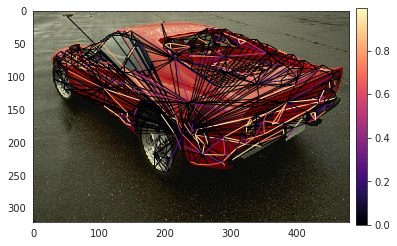

In [33]:
lc = graph.show_rag(regions_aftercut, graph_mean_color, img, edge_width=1, img_cmap=None, border_color=None)
# colbar_lim = (0, 1)
# lc.set_clim(colbar_lim[0], colbar_lim[1])
plt.colorbar(lc, fraction=0.0355, pad=0.02)
plt.imshow(img)  

In [ ]:
print(hola)

In [ ]:
centroids = nx.get_node_attributes(graph_pred, 'centroid').values()
df = pd.DataFrame.from_dict(centroids)


In [ ]:
# Dividing original graph using max number of nodes 
max_num_nodes = 40
num_clusters = 3
alpha = 1000
graph_parted = pre_part_graph(graph_pred, max_num_nodes, df, verbose=True)

In [ ]:
iterm = tqdm(enumerate(range(max_num_nodes - num_clusters)), total=max_num_nodes - num_clusters)
for i in iterm:
    merge_best(graph_parted, df, alpha, num_clusters, verbose=False)
#     plot2d_data(df)

In [ ]:
res = rebuild_labels(df)

In [29]:
plot2d_data(res)

NameError: name 'res' is not defined

In [ ]:
map_array = np.zeros(regions_slic.max() + 1, dtype=regions_slic.dtype)
# Mapping from old labels to new
for n, d in graph_pred.nodes(data=True):
    map_array[d['labels']] = d['cluster']
    


In [ ]:
regions_cham = map_array[regions_slic]
out = color.label2rgb(regions_cham, img, kind='avg')
out = segmentation.mark_boundaries(out, regions_cham, color=(0, 0, 0), mode='thick')
ax = plt.gca()
ax.imshow(out)
